In [1]:
import platform #os 정보를 가져 올 수 있는 모듈

from matplotlib import font_manager, rc # font_manager : 폰트 관리 모듈, rc : 폰트 변경 모듈
from matplotlib import pyplot as plt # 시각화 도구

import seaborn as sns

%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False # 유니코드 표현 설정하기


if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # OS가 APPLE(Darwin)이면 AppleGothic으로 폰트 설정
elif platform.system() == 'Windows':
    path="c:/Windows/Fonts/malgun.ttf" #OS가 윈도우즈면 맑은 고딕으로 설정
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown System... sorry~~~~')

In [2]:
from bs4 import BeautifulSoup # HTML문자열을 DOM 구조화
from urllib.request import urlopen # url을 이용한 http 요청을 하기위한 객체
from urllib.parse import urljoin # url을 굉장히 다루기 쉽게 해준다.

import pandas as pd

# urljoin을 이용해서 크롤링 대상 url 만들기

In [5]:
url_base = 'https://movie.naver.com/'
url_sub  = 'movie/sdb/rank/rmovie.nhn?sel=pnt&date=20200715'

url = urljoin(url_base, url_sub)
url

'https://movie.naver.com/movie/sdb/rank/rmovie.nhn?sel=pnt&date=20200715'

# 영화 평점 랭킹 페이지 가져오기

In [8]:
page = urlopen(url)
soup = BeautifulSoup(page, 'html.parser')

## 영화 평점 페이지 확인 결과
- 테이블 중간 중간 비어있는 항목이 있었다.
 - 따라서 tbody 안의 tr만 사용해서 스크래이핑 할 때 예외 처리가 반드시 필요할 것 같다.
 
- 직접 랭킹, 제목, 평점을 선택해서 가지고 올 것임

In [16]:
print(soup.find('td', class_='ac').find('img').get('alt').strip())
print(soup.find('div', class_='tit5').text.strip())
print(soup.find('td', class_='point').text.strip())

01
그린 북
9.59


크롤링 할 때 공백제거 이외의 특별한 로직에 의해서 수집이 되어야 하면 for 및 zip 문법을 사용하고, 그 외의 경우는 컴프리헨션을 사용

In [74]:
# 컴프리헨션을 사용하는 경우
ranks  = [td.find('img') for td in soup.find_all('td', class_='ac') if td.find('img') is not None ]
ranks  = [ int(rank.get('alt').strip()) for rank in ranks if (rank.get('alt') != "na" and rank.get('alt') !='up' and rank.get('alt') !='down') and (rank.get('alt').isalnum())]
movies = [ movie.text.strip() for movie in soup.find_all('div', class_='tit5') ]
points = [ point.text.strip() for point in soup.find_all('td', class_='point') ]

# 컴프리헨션을 이용하지 않는 경우
rank_list = []
movie_list = []
point_list = []

for rank, movie, point in zip(ranks, movies, points):
    pass

In [75]:
ranks[:5]

[1, 2, 3, 4, 5]

In [76]:
movies[:5]

['그린 북', '가버나움', '베일리 어게인', '원더', '포드 V 페라리']

In [77]:
points[:5]

['9.59', '9.59', '9.53', '9.49', '9.49']

In [78]:
len(ranks), len(movies), len(points)

(50, 50, 50)

In [79]:
df_movie_rank = pd.DataFrame({
    '랭킹': ranks,
    '영화': movies,
    '평점': points
})
df_movie_rank.set_index('랭킹', inplace=True)

In [80]:
df_movie_rank.head()

,영화,평점
랭킹,,
1,그린 북,9.59
2,가버나움,9.59
3,베일리 어게인,9.53
4,원더,9.49
5,포드 V 페라리,9.49


# 100일간 네이버 영화 평점의 변화를 확인하자
- 100일치의 날짜 데이터를 생성
- pandas의 date_range

In [83]:
date = pd.date_range('2020-04-07', periods=100, freq='D')
date

DatetimeIndex(['2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10',
               '2020-04-11', '2020-04-12', '2020-04-13', '2020-04-14',
               '2020-04-15', '2020-04-16', '2020-04-17', '2020-04-18',
               '2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22',
               '2020-04-23', '2020-04-24', '2020-04-25', '2020-04-26',
               '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
               '2020-05-01', '2020-05-02', '2020-05-03', '2020-05-04',
               '2020-05-05', '2020-05-06', '2020-05-07', '2020-05-08',
               '2020-05-09', '2020-05-10', '2020-05-11', '2020-05-12',
               '2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16',
               '2020-05-17', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22', '2020-05-23', '2020-05-24',
               '2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28',
               '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01',
      

tqdm_notebook을 활용해서 진행 상황 시각화
- pip(pip3) install tqdm

In [95]:
import tqdm
import urllib

In [122]:
movie_date = [] # 평점 검색 날짜
movie_name = [] # 영화 제목
movie_point = [] # 해당 일자의 영화 평점 점수

In [123]:
url_base = 'https://movie.naver.com/'
url_sub  = 'movie/sdb/rank/rmovie.nhn?sel=pnt&date={}'

In [124]:
for today in tqdm.notebook.tqdm(date):
    # yyyy-mm-dd 형식의 날짜 형식을 yyyymmdd 형식으로 바꿔주기
    today = urllib.parse.quote(today.strftime('%Y%m%d'))
    url_formated = url_sub.format(today)
    url = urljoin(url_base, url_formated)
    
    page = urlopen(url)
    soup = BeautifulSoup(page, 'html.parser')
    
    # 조회한 날짜마다의 영화의 제목과 평점을 한꺼번에 구하기
    movies = [ movie.text.strip() for movie in soup.find_all('div', class_='tit5') ]
    points = [ float(point.text.strip()) for point in soup.find_all('td', class_='point') ]
     
    
    movie_date.extend([ today for n in range(0, len(movies)) ]) # 날짜 데이터 리스트 추가
    movie_name.extend(movies)
    movie_point.extend(points)
    

In [125]:
movie_df = pd.DataFrame({
    'date': movie_date,
    'name': movie_name,
    'point': movie_point
})

movie_df.head()

,date,name,point
0,20200407,그린 북,9.60
1,20200407,가버나움,9.58
2,20200407,베일리 어게인,9.52
3,20200407,포드 V 페라리,9.50
4,20200407,주전장,9.50


# 100간의 평균 평점이 높은 순으로 정렬하기

In [126]:
import numpy as np

In [127]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    5000 non-null   object 
 1   name    5000 non-null   object 
 2   point   5000 non-null   float64
dtypes: float64(1), object(2)
memory usage: 117.3+ KB


In [128]:
movie_agg = pd.pivot_table(movie_df, index=['name'], values='point', aggfunc=np.mean)
movie_best = movie_agg.sort_values(by='point', ascending=False)
movie_best.head()

,point
name,
그린 북,9.593200
가버나움,9.584700
베일리 어게인,9.525600
아이즈 온 미 : 더 무비,9.521667
포드 V 페라리,9.495700


,date,name,point
28,20200407,어벤져스: 엔드게임,9.38
78,20200408,어벤져스: 엔드게임,9.38
128,20200409,어벤져스: 엔드게임,9.38
178,20200410,어벤져스: 엔드게임,9.38
228,20200411,어벤져스: 엔드게임,9.38


In [159]:
for name in movie_df['name'].unique():
    print(name)

그린 북
가버나움
베일리 어게인
포드 V 페라리
주전장
아일라
원더
당갈
쇼생크 탈출
터미네이터 2:오리지널
보헤미안 랩소디
덕구
나 홀로 집에
월-E
살인의 추억
빽 투 더 퓨쳐
인생은 아름다워
사운드 오브 뮤직
포레스트 검프
매트릭스
라이언 일병 구하기
헬프
글래디에이터
센과 치히로의 행방불명
위대한 쇼맨
클래식
토이 스토리 3
안녕 베일리
어벤져스: 엔드게임
알라딘
헌터 킬러
레옹
죽은 시인의 사회
타이타닉
아이 캔 스피크
집으로...
반지의 제왕: 왕의 귀환
동주
캐스트 어웨이
여인의 향기
굿바이 마이 프랜드
굿 윌 헌팅
주토피아
서유기 2 - 선리기연
달링
히든 피겨스
클레멘타인
모노노케 히메
쉰들러 리스트
세 얼간이
아이즈 온 미 : 더 무비


No handles with labels found to put in legend.


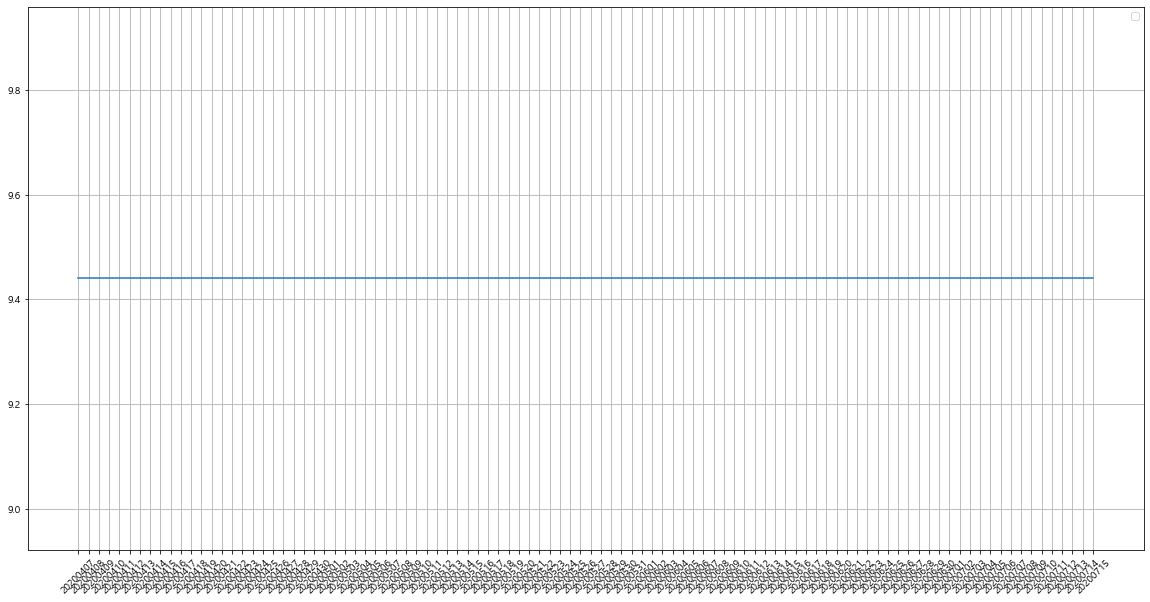

In [160]:
df_search = movie_df.query('name==["터미네이터 2:오리지널"]')

plt.figure(figsize=(20, 10))
plt.plot(df_search['date'], df_search['point'])
plt.legend(loc='best')
plt.xticks(df_search['date'], rotation='45')
plt.grid()
plt.show()

# 영화별 평점 확인하기

In [161]:
movie_pivot = pd.pivot_table(movie_df, index=['date'], columns=['name'], values=['point'])
movie_pivot.head()

point                                                                \
name      가버나움 굿 윌 헌팅 굿바이 마이 프랜드 그린 북 글래디에이터 나 홀로 집에    달링    당갈    덕구    동주   
date                                                                           
20200407  9.58   9.35       9.35  9.6   9.39    9.41  9.35  9.47  9.42  9.36   
20200408  9.58   9.35       9.35  9.6   9.39    9.41  9.35  9.47  9.42  9.36   
20200409  9.58   9.35       9.35  9.6   9.39    9.41  9.35  9.47  9.42  9.36   
20200410  9.58   9.35       9.35  9.6   9.39    9.41  9.35  9.47  9.41  9.37   
20200411  9.58   9.35       9.35  9.6   9.39    9.41  9.35  9.47  9.41  9.37   

          ...                                                                 \
name      ...   클래식 클레멘타인  타이타닉 터미네이터 2:오리지널 토이 스토리 3 포드 V 페라리 포레스트 검프 헌터 킬러   
date      ...                                                                  
20200407  ...  9.38  9.35  9.37         9.44     9.38      9.5     9.4  9.38   
20200408  ...  9.38  9.35  9.37         9.44     9.38      9.5     9.4  9.38   
20200409  ...  9.38  9.35  9.37         9.44     9.38      9.5     9.4  9.38   
20200410  ...  9.38  9.35  9.37         9.44     9.38      9.5     9.4  9.37   
20200411  ...  9.38  9.35  9.37         9.44     9.38      9.5     9.4  9.37   

                       
name        헬프 히든 피겨스  
date                   
20200407  9.39   9.35  
20200408  9.39   9.35  
20200409  9.39   9.35  
20200410  9.39   9.35  
20200411  9.39   9.35  

[5 rows x 51 columns]

pivot_table을 활용하여 컬럼의 변화가 일어 났을 때 원래 있던 컬럼 때문에 컬럼의 레벨이 올라가면 droplevel()을 활용하여 상위 컬럼 레벨을 하나씩 줄여갈 수 있다.

In [163]:
movie_pivot.columns = movie_pivot.columns.droplevel()
movie_pivot.head()

name,가버나움,굿 윌 헌팅,굿바이 마이 프랜드,그린 북,글래디에이터,나 홀로 집에,달링,당갈,덕구,동주,...,클래식,클레멘타인,타이타닉,터미네이터 2:오리지널,토이 스토리 3,포드 V 페라리,포레스트 검프,헌터 킬러,헬프,히든 피겨스
date,,,,,,,,,,,,,,,,,,,,,
20200407,9.58,9.35,9.35,9.6,9.39,9.41,9.35,9.47,9.42,9.36,...,9.38,9.35,9.37,9.44,9.38,9.5,9.4,9.38,9.39,9.35
20200408,9.58,9.35,9.35,9.6,9.39,9.41,9.35,9.47,9.42,9.36,...,9.38,9.35,9.37,9.44,9.38,9.5,9.4,9.38,9.39,9.35
20200409,9.58,9.35,9.35,9.6,9.39,9.41,9.35,9.47,9.42,9.36,...,9.38,9.35,9.37,9.44,9.38,9.5,9.4,9.38,9.39,9.35
20200410,9.58,9.35,9.35,9.6,9.39,9.41,9.35,9.47,9.41,9.37,...,9.38,9.35,9.37,9.44,9.38,9.5,9.4,9.37,9.39,9.35
20200411,9.58,9.35,9.35,9.6,9.39,9.41,9.35,9.47,9.41,9.37,...,9.38,9.35,9.37,9.44,9.38,9.5,9.4,9.37,9.39,9.35


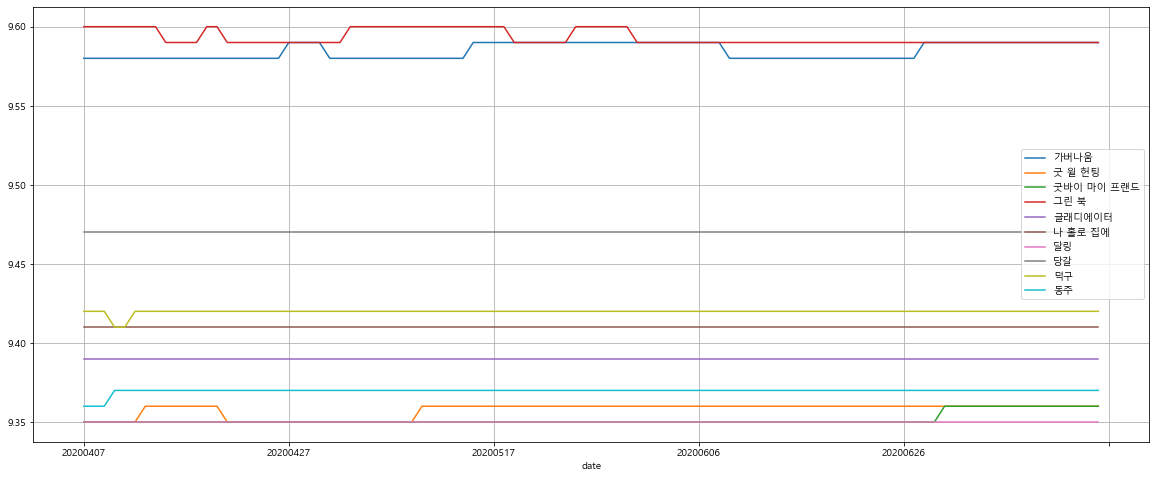

In [166]:
movie_name=['위대한 쇼맨', '클래식','토이 스토리 3','안녕 베일리','어벤져스: 엔드게임','알라딘','헌터 킬러']
movie_pivot.plot(y=movie_pivot.columns[:10], figsize=(20, 8))
plt.legend(loc='best')
plt.grid()
plt.show()